# PAC-Bayes Bounds: Interactive Exploration

This notebook provides an interactive way to explore the trajectory-aware PAC-Bayes bounds implementation.

In [1]:
import sys
sys.path.append('..')

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader import get_mnist_binary
from src.models import create_model, count_parameters
from src.training import train_model_with_trajectory
from src.hessian_estimator import TrajectoryHessianEstimator
from src.pac_bayes_bounds import GaussianPACBayesBound, compute_baseline_pac_bayes_bound
from src.utils import set_random_seed

sns.set_style('whitegrid')
%matplotlib inline

## 1. Load Data

In [2]:
# Set random seed for reproducibility
set_random_seed(42)

# Load MNIST binary classification (0 vs 1)
train_loader, val_loader, test_loader, input_dim = get_mnist_binary(
    data_dir='../data',
    class_0=0,
    class_1=1,
    batch_size=128,
    flatten=True,
    seed=42
)

print(f"Input dimension: {input_dim}")
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

Loading MNIST via Keras (SSL verification disabled)...
✓ MNIST loaded successfully
Input dimension: 784
Training samples: 10766
Validation samples: 1899
Test samples: 2115


## 2. Create and Train Model

In [3]:
# Create logistic regression model
model = create_model('logistic', input_dim)
n_params = count_parameters(model)
print(f"Model parameters: {n_params}")

# Train with trajectory recording
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

model, history = train_model_with_trajectory(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=50,
    lr=0.01,
    optimizer_type='sgd',
    device=device,
    record_every=5,
    seed=42,
    verbose=True
)

Model parameters: 785
Using device: cpu


Training: 100%|███████████| 50/50 [00:01<00:00, 28.51it/s, train_loss=0.0104, val_loss=0.0086, train_acc=0.9979, val_acc=0.9984]


## 3. Visualize Training

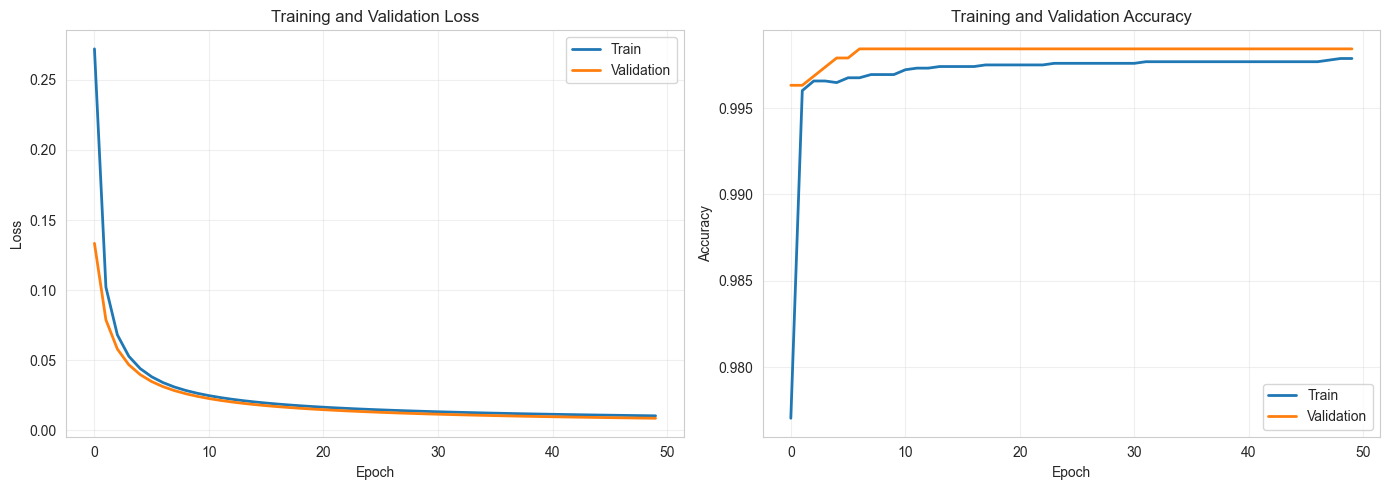

Trajectory length: 10


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot losses
axes[0].plot(history['train_losses'], label='Train', linewidth=2)
axes[0].plot(history['val_losses'], label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot accuracies
axes[1].plot(history['train_accs'], label='Train', linewidth=2)
axes[1].plot(history['val_accs'], label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Trajectory length: {len(history['trajectory'])}")

## 4. Compute Trajectory-Averaged Hessian

In [5]:
# Estimate trajectory-averaged Hessian
hessian_estimator = TrajectoryHessianEstimator(
    model=model,
    trajectory=history['trajectory'],
    data_loader=train_loader,
    criterion=torch.nn.BCELoss(),
    device=device,
    lambda_reg=0.01,
    c_Q=1.0,
    use_diagonal=True,
    num_hess_samples=50,
    verbose=True
)

mu_Q, Sigma_Q = hessian_estimator.get_posterior_params()
print(f"\nPosterior mean shape: {mu_Q.shape}")
print(f"Posterior covariance shape: {Sigma_Q.shape}")

Computing trajectory-averaged Hessian (T=10, d=785)...


Trajectory Hessian: 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.81s/it]

Computing posterior covariance...

Posterior mean shape: torch.Size([785])
Posterior covariance shape: torch.Size([785])


## 5. Compute PAC-Bayes Bounds

In [6]:
# Define prior
prior_variance = 1.0
mu_P = torch.zeros_like(mu_Q)
Sigma_P = torch.ones_like(Sigma_Q) * prior_variance

# Compute empirical risks
from src.training import TrajectoryTrainer
trainer = TrajectoryTrainer(
    model=model,
    optimizer=None,
    criterion=torch.nn.BCELoss(),
    device=device,
    verbose=False
)

train_risk = trainer.compute_empirical_risk(train_loader)
val_risk = trainer.compute_empirical_risk(val_loader)
test_risk = trainer.compute_empirical_risk(test_loader)

print(f"Train risk: {train_risk:.4f}")
print(f"Val risk: {val_risk:.4f}")
print(f"Test risk: {test_risk:.4f}")

Train risk: 0.0103
Val risk: 0.0086
Test risk: 0.0062


In [7]:
# Compute trajectory-aware bound
pac_bayes_computer = GaussianPACBayesBound(
    mu_P=mu_P,
    Sigma_P=Sigma_P,
    mu_Q=mu_Q,
    Sigma_Q=Sigma_Q,
    r=10,
    device=device,
    use_diagonal=True
)

kl_decomposition = pac_bayes_computer.compute_kl_decomposition(num_hutchinson_samples=100)
bound_info = pac_bayes_computer.compute_pac_bayes_bound(
    empirical_risk=train_risk,
    n_samples=len(train_loader.dataset),
    delta=0.05
)

print("\nTrajectory-Aware PAC-Bayes Bound:")
print(f"  Bound: {bound_info['pac_bayes_bound']:.4f}")
print(f"  KL divergence: {bound_info['kl_divergence']:.4f}")
print(f"  Bound term: {bound_info['bound_term']:.4f}")


Trajectory-Aware PAC-Bayes Bound:
  Bound: 1.2682
  KL divergence: 34069.3454
  Bound term: 1.2579


In [8]:
# Compute baseline bound
baseline_bound = compute_baseline_pac_bayes_bound(
    empirical_risk=train_risk,
    n_samples=len(train_loader.dataset),
    d=n_params,
    delta=0.05,
    prior_variance=1.0,
    posterior_variance=0.01
)

print("\nBaseline Isotropic PAC-Bayes Bound:")
print(f"  Bound: {baseline_bound['pac_bayes_bound']:.4f}")
print(f"  KL divergence: {baseline_bound['kl_divergence']:.4f}")


Baseline Isotropic PAC-Bayes Bound:
  Bound: 0.2673
  KL divergence: 1418.9543


## 6. Visualize Results

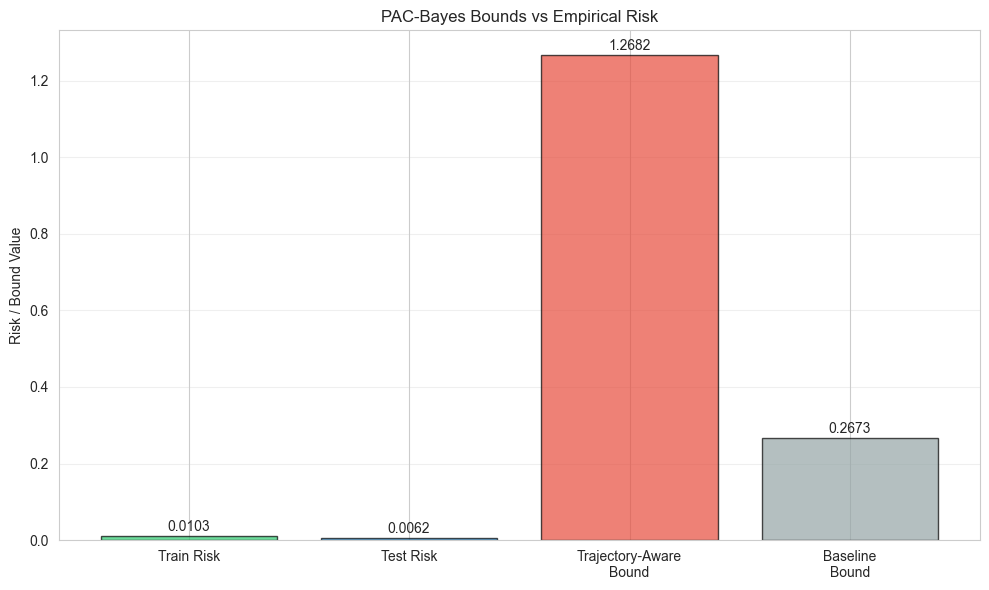

In [9]:
# Bound comparison
fig, ax = plt.subplots(figsize=(10, 6))

labels = ['Train Risk', 'Test Risk', 'Trajectory-Aware\nBound', 'Baseline\nBound']
values = [train_risk, test_risk, bound_info['pac_bayes_bound'], baseline_bound['pac_bayes_bound']]
colors = ['#2ecc71', '#3498db', '#e74c3c', '#95a5a6']

bars = ax.bar(labels, values, color=colors, alpha=0.7, edgecolor='black')

ax.set_ylabel('Risk / Bound Value')
ax.set_title('PAC-Bayes Bounds vs Empirical Risk')
ax.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{value:.4f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [10]:
# KL decomposition
print("\nKL Decomposition:")
for key, value in kl_decomposition.items():
    print(f"  {key}: {value:.4f}")


KL Decomposition:
  mean_alignment: 4.3082
  trace_term: 72465.3438
  dimension_term: -785.0000
  log_det_term: -3545.9612
  total_kl: 34069.3454


## 7. Experiment with Hyperparameters

Try varying:
- `c_Q`: Posterior scaling constant
- `lambda_reg`: Regularization parameter
- `projection_dim`: Top-subspace dimension
- `num_hessian_samples`: Number of samples for Hessian estimation

c_Q = 0.1: bound = 0.0320
c_Q = 0.5: bound = 0.5975
c_Q = 1.0: bound = 1.2693
c_Q = 2.0: bound = 2.5825
c_Q = 5.0: bound = 6.4895


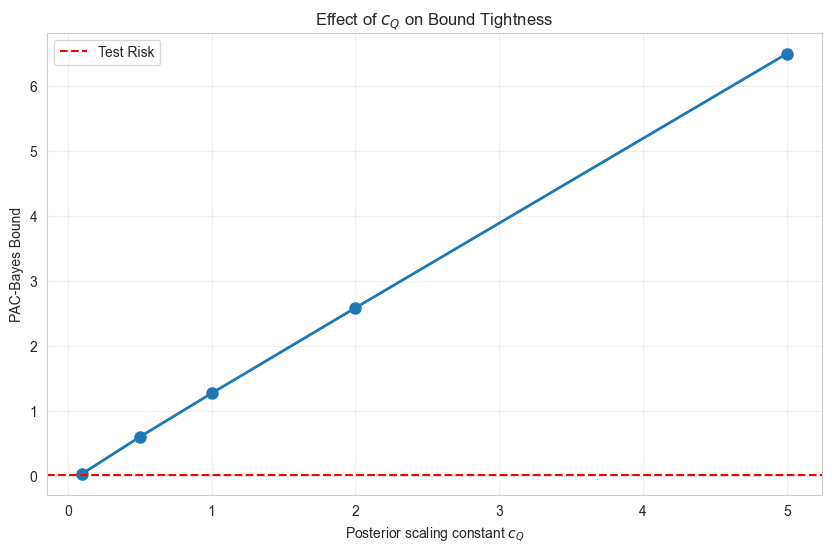

In [12]:
# Example: vary c_Q and observe bound tightness
c_Q_values = [0.1, 0.5, 1.0, 2.0, 5.0]
bounds = []

for c_Q in c_Q_values:
    hess_est = TrajectoryHessianEstimator(
        model=model,
        trajectory=history['trajectory'],
        data_loader=train_loader,
        criterion=torch.nn.BCELoss(),
        device=device,
        lambda_reg=0.01,
        c_Q=c_Q,
        use_diagonal=True,
        num_hess_samples=30,
        verbose=False
    )
    
    mu_Q_temp, Sigma_Q_temp = hess_est.get_posterior_params()
    
    pac_computer = GaussianPACBayesBound(
        mu_P=mu_P,
        Sigma_P=Sigma_P,
        mu_Q=mu_Q_temp,
        Sigma_Q=Sigma_Q_temp,
        r=10,
        device=device,
        use_diagonal=True
    )
    
    bound = pac_computer.compute_pac_bayes_bound(
        empirical_risk=train_risk,
        n_samples=len(train_loader.dataset),
        delta=0.05
    )
    
    bounds.append(bound['pac_bayes_bound'])
    print(f"c_Q = {c_Q:.1f}: bound = {bound['pac_bayes_bound']:.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(c_Q_values, bounds, 'o-', linewidth=2, markersize=8)
plt.axhline(y=test_risk, color='r', linestyle='--', label='Test Risk')
plt.xlabel('Posterior scaling constant $c_Q$')
plt.ylabel('PAC-Bayes Bound')
plt.title('Effect of $c_Q$ on Bound Tightness')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()